# **Logistic Regression**

---

## **Introduction**
Logistic Regression is a supervised learning algorithm used for **binary and multi-class classification**. Unlike Linear Regression, which predicts continuous values, Logistic Regression predicts probabilities and uses a **sigmoid function** to map outputs to the range $[0,1]$.

---

## **Methodology**

### **1. Problem Definition**
Suppose we have a dataset with $ N $ samples, where each sample $ \mathbf{x}_j $ is a $ d $-dimensional vector:

$$
\mathbf{x}_j = (x_{j1}, x_{j2}, \dots, x_{jd})
$$

Each sample belongs to one of two classes $ y_j \in \{0,1\} $. The goal of Logistic Regression is to model the probability that a given sample belongs to class 1:

$$
P(y=1 | \mathbf{x}) = h(\mathbf{x})
$$

where $ h(\mathbf{x}) $ is the hypothesis function.

### **2. Sigmoid Function**
The hypothesis function is modeled using a **sigmoid function**:

$$
h(\mathbf{x}) = \frac{1}{1 + e^{-(\mathbf{w}^T\mathbf{x} + b)}}
$$

where:
- $ \mathbf{w} $ is the weight vector.
- $ b $ is the bias term.

The sigmoid function ensures that the output is always between $ 0 $ and $ 1 $, making it interpretable as a probability.

### **3. Cost Function (NLL)**
The cost function for logistic regression is based on the **log-likelihood** of the data:

$$
J(\mathbf{w}, b) = -\frac{1}{N} \sum_{j=1}^{N} \left[ y_j \log h(\mathbf{x}_j) + (1 - y_j) \log (1 - h(\mathbf{x}_j)) \right]
$$


### **4. Optimization using Gradient Descent**
To minimize the cost function, we use **gradient descent**:

$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}
$$

$$
b := b - \alpha \frac{\partial J}{\partial b}
$$

where $ \alpha $ is the learning rate. The gradients are computed as:

$$
\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{N} \sum_{j=1}^{N} (h(\mathbf{x}_j) - y_j) \mathbf{x}_j
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{N} \sum_{j=1}^{N} (h(\mathbf{x}_j) - y_j)
$$

### **5. Decision Rule**
After training, predictions are made using:

$$
\hat{y} =
\begin{cases} 
1, & \text{if } h(\mathbf{x}) \geq 0.5 \\
0, & \text{if } h(\mathbf{x}) < 0.5
\end{cases}
$$

For multi-class classification, we extend Logistic Regression using **Softmax Regression**.

---

## **Prerequisites**
- `numpy`
- `scikit-learn`
- `matplotlib`

---

The following is an example of using Logistic Regression to analyze EEG data recorded in a driving simulation experiment. The goal is to classify **steering angles** based on EEG signals.

You can try applying Logistic Regression to other BCI (Brain-Computer Interface) datasets.


## **main experiment**
- make binary/multiple label
- logistic regreesion for classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import (
    load_npz_files,
    z_score_norm,
    session_wise_grouping,
    make_binary_label,
    make_multi_label,
    load_data_model,
)

from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward2.npz"
data_list = load_data_model(data_dir)
train_data, train_label, test_data, test_label = data_list["feature_train"], data_list["steering_train"], data_list["feature_test"], data_list["steering_test"]

# simply flatten the data from (sample, channel, timepoint) to (sample, channel*timepoint)
train_data = np.reshape(train_data, (train_data.shape[0], -1))
test_data = np.reshape(test_data, (test_data.shape[0], -1))

# make binary labels
# train_label = make_binary_label(train_label)
# test_label = make_binary_label(test_label)

# make multi labels
split_list = [-1, -0.1, 0.1, 1]
train_label = make_multi_label(train_label, split_list)
test_label = make_multi_label(test_label, split_list)

In [3]:
# logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_data, train_label)
# predict
pred = model.predict(test_data)
# calculate accuracy
accuracy = accuracy_score(test_label, pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 63.62%


## **supplementary experiment**
- confusion matrix
- ROC curve

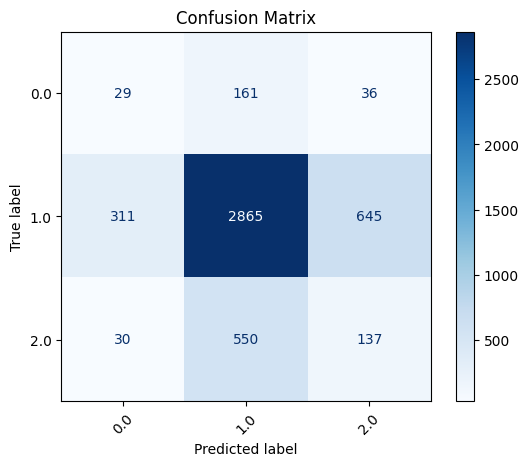

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_label, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_label))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

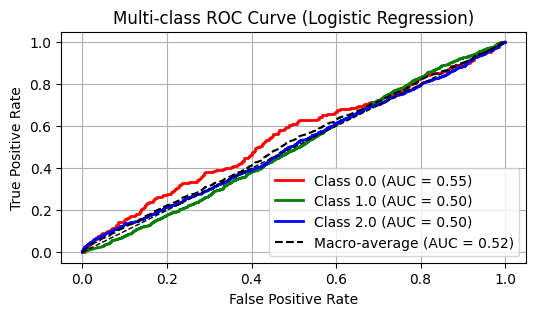

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

classes = np.unique(train_label)
train_label_bin = label_binarize(train_label, classes=classes)
test_label_bin = label_binarize(test_label, classes=classes)
n_classes = train_label_bin.shape[1]

model_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
model_ovr.fit(train_data, train_label_bin)

y_score = model_ovr.predict_proba(test_data)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_label_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(6, 6))
colors = ['red', 'green', 'blue']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})", color=colors[i])
plt.plot(fpr["macro"], tpr["macro"], 'k--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The results show that the value of AUC is close to 0.5, and the model has not learned effective features. The problem can not be solved by a simple linear model.